<h1>NEW HAMPSHIRE TEMPERATURE TIME SERIES NOTEBOOK</h1>


--------

In [1]:
# import libraries

import pandas as pd
import requests
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#import data set

from vega_datasets import data
from io import StringIO


# warnings

import warnings

# graphing parameters

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

---

<h2>Acquire</h2>

----

In [2]:
df = pd.read_csv('new_hampshire_temps.csv', index_col=0)

In [3]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1743-11-01,-0.507,1.848,New Hampshire,United States
1743-12-01,NaN,NaN,New Hampshire,United States
1744-01-01,NaN,NaN,New Hampshire,United States
1744-02-01,NaN,NaN,New Hampshire,United States
1744-03-01,NaN,NaN,New Hampshire,United States


In [4]:
df.tail()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
2013-05-01,13.129,0.383,New Hampshire,United States
2013-06-01,17.862,0.350,New Hampshire,United States
2013-07-01,21.938,0.369,New Hampshire,United States
2013-08-01,18.498,0.271,New Hampshire,United States
2013-09-01,14.564,1.226,New Hampshire,United States


In [5]:
df.AverageTemperatureUncertainty.value_counts()

0.215    12
0.252    11
0.251    11
0.298    11
0.295    11
         ..
1.018     1
1.312     1
3.681     1
2.466     1
2.500     1
Name: AverageTemperatureUncertainty, Length: 1734, dtype: int64

In [6]:
# Let's check for null values and zeros

In [7]:
def missing_values_table(df):
    
    '''This function will look at any data set and report back on zeros and nulls for every column while also giving percentages of total values
        and also the data types. The message prints out the shape of the data frame and also tells you how many columns have nulls '''
    
    
    
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    null_count = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, null_count, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'null_count', 2 : '% of Total Values'})
    mz_table['Total Zeroes + Null Values'] = mz_table['Zero Values'] + mz_table['null_count']
    mz_table['% Total Zero + Null Values'] = 100 * mz_table['Total Zeroes + Null Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] >= 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " +  str((mz_table['null_count'] != 0).sum()) +
          " columns that have NULL values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)

    return mz_table

In [8]:
missing_values_table(df)

Your selected dataframe has 4 columns and 3239 Rows.
There are 2 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
AverageTemperature,0,120,3.7,120,3.7,float64
AverageTemperatureUncertainty,0,120,3.7,120,3.7,float64
State,0,0,0.0,0,0.0,object
Country,0,0,0.0,0,0.0,object


---

<h2>Prepare</h2>

----

**To Do For Prep**

1. rename columns
2. remove null values
3. convert temperature to farenheit from celsius
4. convert index to datetime 
5. create season column (but don't use initially)
6. get rid of values before 1880 as the temperature uncertainty is way too high

In [9]:
# let's prep the data for exploration

def prep_data(df):
    '''
    The function takes in a dataframe and returns a dataframe with 
    re-named columns for readability, removed Null values from the dataset,
    a converted average temperature column that now reads in farenheit instead of
    celsius and finally an index that has been converted into date-time.
    '''
  
    # rename columns
    df.columns = ['average_temperature', 'average_uncertainty', 'state', 'country']
    
    # Remove NaNs from average temperature
    df.loc[df['average_temperature'].isin(['NaN'])].head()
    indexsize = df.loc[df['average_temperature'].isin(['NaN'])].index
    df.drop(indexsize , inplace=True)
    
    # convert temperature column to degrees farenheit and then round to 2 digits
    df = df.assign(average_temperature = lambda x: (9/5)*x['average_temperature']+32)
    df['average_temperature'] = round(df.average_temperature, 2)
    
    # convert index to datetime
    df.index = pd.to_datetime(df.index)
    
    old_years = df.loc[df.index < '1880-'].index
    df.drop(old_years , inplace=True)
    
    # drop average uncertainty column
    #cols = ['average_uncertainty']
    #df.drop(columns=cols, inplace=True)
    
    #create season column
    df['season'] = (df.index.month%12 + 3)//3

    seasons = {
             1: 'Winter',
            2: 'Spring',
            3: 'Summer',
             4: 'Autumn'
                        }

    df['season_name'] = df['season'].map(seasons)
    
    # create column for month
    df['month'] = df.index.month
    
    months = {
             1: 'January',
            2: 'February',
            3: 'March',
             4: 'April',
            5: 'May',
            6: 'June',
            7: 'July',
            8: 'August',
            9: 'September',
            10: 'October',
            11: 'November',
            12: 'December'
                        }
    df['month_name'] = df['month'].map(months)
    
    #drop object columns
    cols = ['state', 'country', 'season', 'month']
    df.drop(columns=cols, inplace=True)
    
    
    return df

In [10]:
df = prep_data(df)

In [11]:
df.shape

(1605, 4)

In [12]:
df.head(2)

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
1880-01-01,24.09,0.981,Winter,January
1880-02-01,21.66,0.562,Winter,February


In [13]:
df.tail()

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
2013-05-01,55.63,0.383,Spring,May
2013-06-01,64.15,0.350,Summer,June
2013-07-01,71.49,0.369,Summer,July
2013-08-01,65.30,0.271,Summer,August
2013-09-01,58.22,1.226,Autumn,September


In [14]:
df.average_temperature.max()

71.49

In [15]:
df.average_temperature.min()

6.95

In [16]:
df.head()

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
1880-01-01,24.09,0.981,Winter,January
1880-02-01,21.66,0.562,Winter,February
1880-03-01,25.02,0.800,Spring,March
1880-04-01,40.20,0.462,Spring,April
1880-05-01,57.67,0.931,Spring,May


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1605 entries, 1880-01-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   average_temperature  1605 non-null   float64
 1   average_uncertainty  1605 non-null   float64
 2   season_name          1605 non-null   object 
 3   month_name           1605 non-null   object 
dtypes: float64(2), object(2)
memory usage: 62.7+ KB


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [18]:
# set train size to be 70% of total 
train_size = int(len(df) * .7)
train_size

1123

In [19]:
# set validate size to be 20% of total 
validate_size = int(len(df) * .2)
validate_size

321

In [20]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

161

In [21]:
# validate will go from 
validate_end_index = train_size + validate_size
validate_end_index

1444

In [22]:
# train will go from 0 to
train = df[: train_size]
# validate will go from 
validate = df[train_size:validate_end_index]
# test will include to the end
test = df[validate_end_index:]

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [23]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [24]:
print(df.head(1) == train.head(1))

            average_temperature  average_uncertainty  season_name  month_name
dt                                                                           
1880-01-01                 True                 True         True        True


In [25]:
pd.concat([train.tail(1), validate.head(1)])

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
1973-07-01,68.92,0.330,Summer,July
1973-08-01,69.34,0.308,Summer,August


In [26]:
pd.concat([validate.tail(1), test.head(1)])

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
2000-04-01,41.29,0.155,Spring,April
2000-05-01,53.55,0.282,Spring,May


---

<h2>Explore</h2>

----

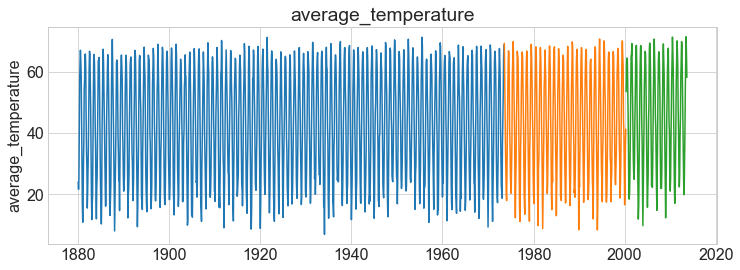

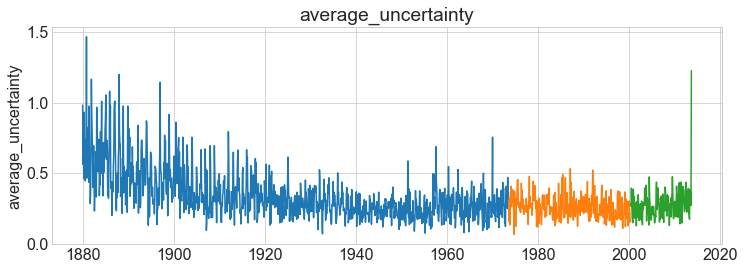

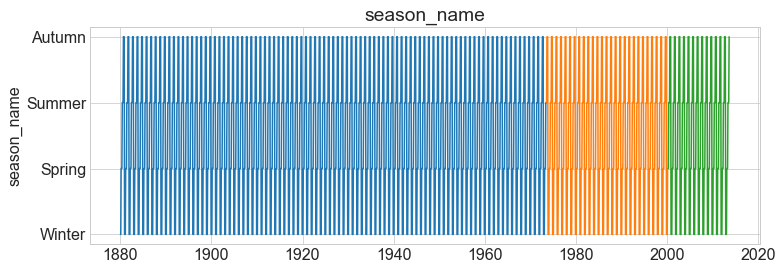

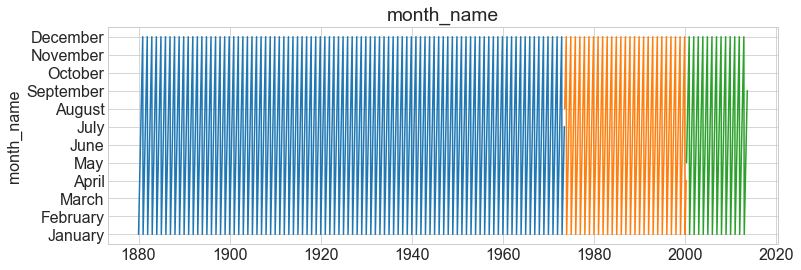

In [27]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

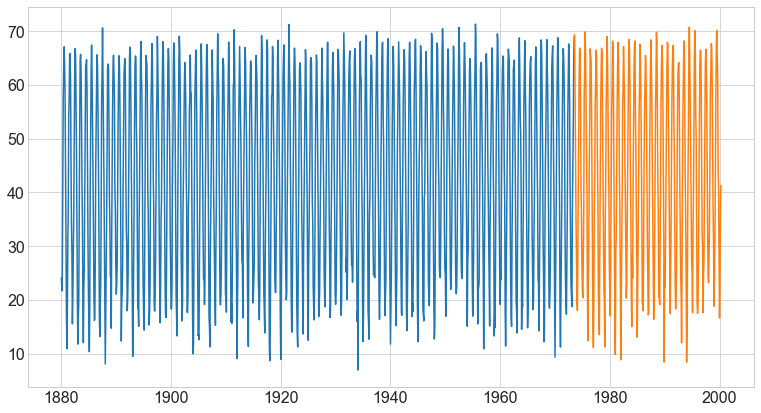

In [28]:
plt.plot(train.index, train.average_temperature)
plt.plot(validate.index, validate.average_temperature)
plt.show()

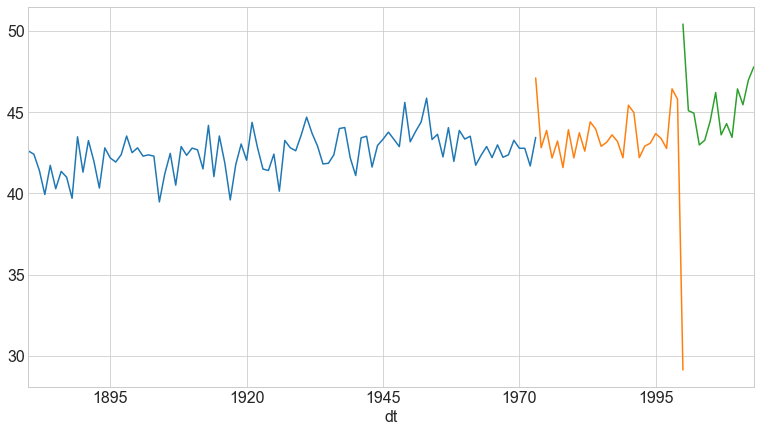

In [29]:
# Visualize the split data:

train.resample('Y').average_temperature.mean().plot()
validate.resample('Y').average_temperature.mean().plot()
test.resample('Y').average_temperature.mean().plot()
plt.show()

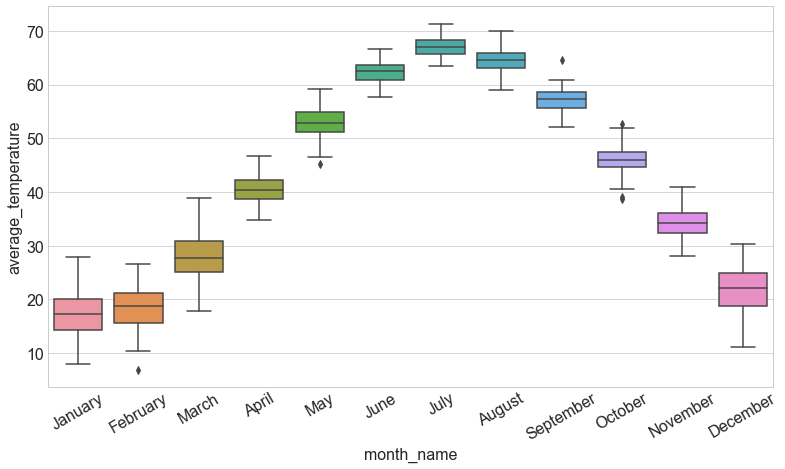

In [30]:
# Energy consumption by month on train
x = sns.boxplot(data = train, x = 'month_name', y = 'average_temperature')
x.set_xticklabels(x.get_xticklabels(), rotation=30)
plt.show()

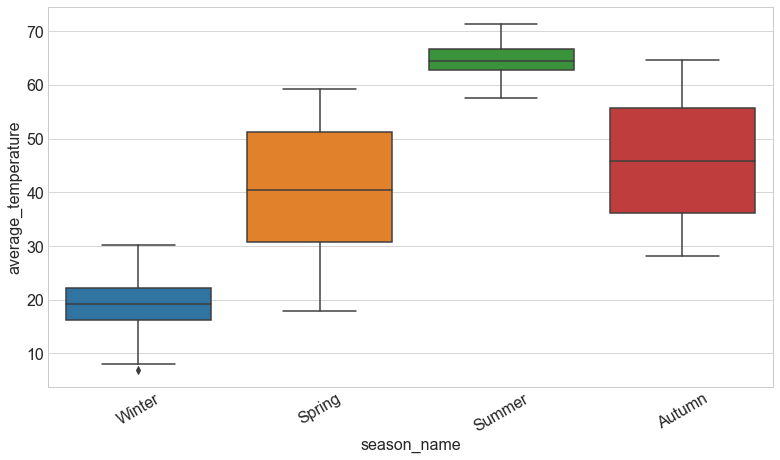

In [31]:
# Energy consumption by season on train
x = sns.boxplot(data = train, x = 'season_name', y = 'average_temperature')
x.set_xticklabels(x.get_xticklabels(), rotation=30)
plt.show()

In [32]:
y = train.average_temperature
table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).mean().unstack(0)

table.head(12)

dt,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973
dt,,,,,,,,,,,,,,,,,,,,,
01-Jan,24.09,10.91,15.55,11.77,12.03,16.30,16.17,13.16,8.07,24.05,...,20.73,14.81,18.19,23.15,12.18,18.42,9.35,11.22,19.15,20.86
02-Feb,21.66,18.31,20.90,16.85,22.19,10.36,16.39,17.72,16.96,14.73,...,18.70,18.04,20.23,14.21,14.59,21.42,19.83,20.47,17.31,18.75
03-Mar,25.02,30.31,27.63,19.43,25.93,17.93,25.62,22.78,23.74,30.61,...,30.83,28.21,30.88,24.91,31.69,27.16,27.97,27.37,26.36,36.06
04-Apr,40.20,37.26,36.13,37.40,39.48,40.35,43.78,36.17,35.64,43.33,...,40.14,38.62,38.84,38.90,45.22,41.68,40.91,38.35,36.10,43.33
05-May,57.67,54.29,47.35,51.26,51.07,51.86,52.95,57.22,50.41,56.27,...,56.52,55.85,50.28,46.45,51.23,51.77,55.13,52.48,54.06,51.72
06-Jun,63.49,57.69,61.55,64.54,63.71,62.32,60.42,62.19,62.91,63.71,...,61.95,61.64,63.06,65.16,60.62,63.11,62.46,63.16,61.48,64.46
07-Jul,67.09,65.70,66.76,65.70,63.69,67.42,65.62,70.62,63.90,65.53,...,68.24,64.18,67.07,68.38,68.45,65.68,68.81,66.76,67.63,68.92
08-Aug,63.54,65.84,65.44,62.75,64.72,62.14,63.57,61.95,63.37,62.20,...,60.15,65.30,65.27,65.82,63.29,67.27,66.76,65.36,63.70,NaN
09-Sep,58.03,60.85,57.14,54.01,59.01,53.85,55.71,52.81,53.84,57.70,...,54.76,57.52,54.49,57.02,59.87,58.22,58.08,60.63,57.41,NaN


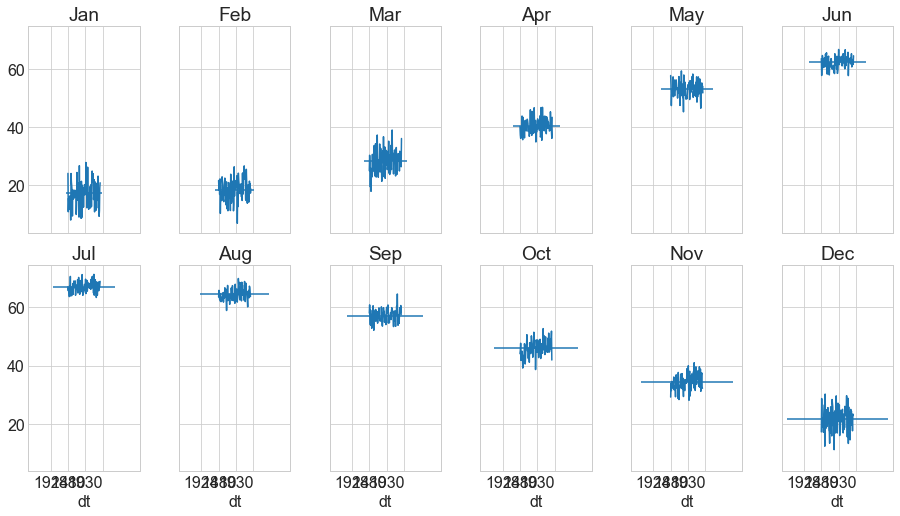

In [33]:
# lets make a subseasonal plot
with plt.style.context('seaborn-whitegrid'):
    fig, axs = plt.subplots(2, 6, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)
fig.tight_layout()
for ax, (month, x) in zip(axs.ravel(), table.T.iteritems()):
    x.plot(ax=ax, title=month[3:])
    ax.hlines(x.mean(), *ax.get_xlim())

In [34]:
decomposition = sm.tsa.seasonal_decompose(train.resample('2M').average_temperature.mean(), model='additive')

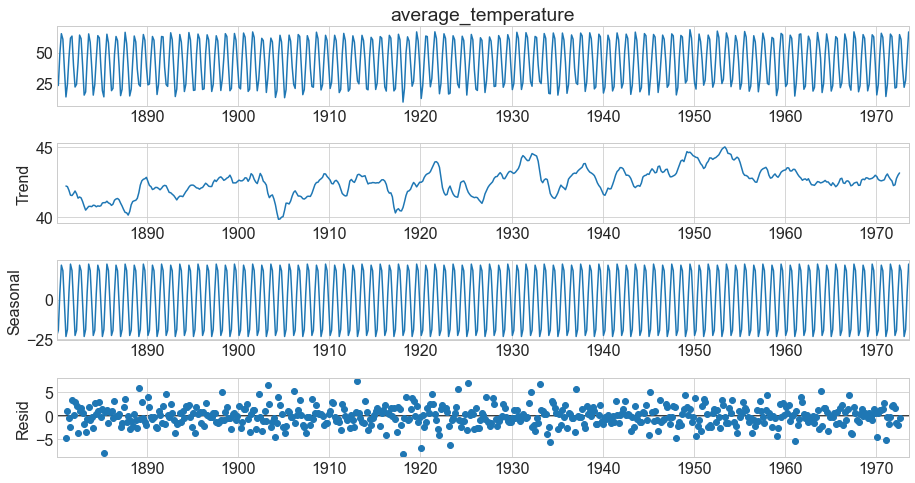

In [35]:
decomposition.plot()
None

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

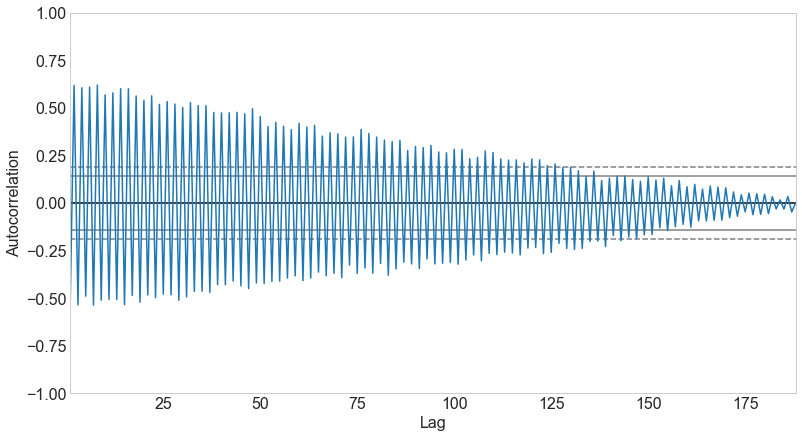

In [36]:
# autocorrelation plot 
pd.plotting.autocorrelation_plot(train.average_temperature.resample('6M').mean())

In [37]:
train.average_temperature.resample('6M').mean()

dt
1880-01-31    24.090000
1880-07-31    45.855000
1881-01-31    37.171667
1881-07-31    43.926667
1882-01-31    41.661667
                ...    
1971-07-31    44.765000
1972-01-31    42.105000
1972-07-31    43.823333
1973-01-31    39.836667
1973-07-31    47.206667
Freq: 6M, Name: average_temperature, Length: 188, dtype: float64

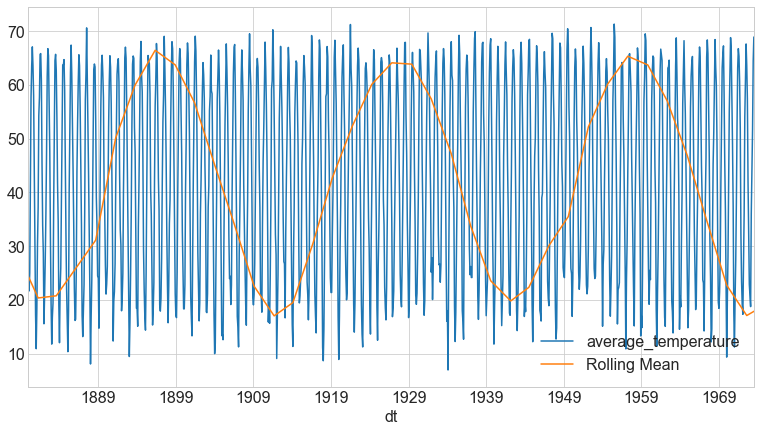

In [38]:
# plot the average temperature

train.average_temperature.plot(label="average_temperature")
plt.plot(train['average_temperature'].rolling('90D').mean(), label="Rolling Mean")
plt.legend()

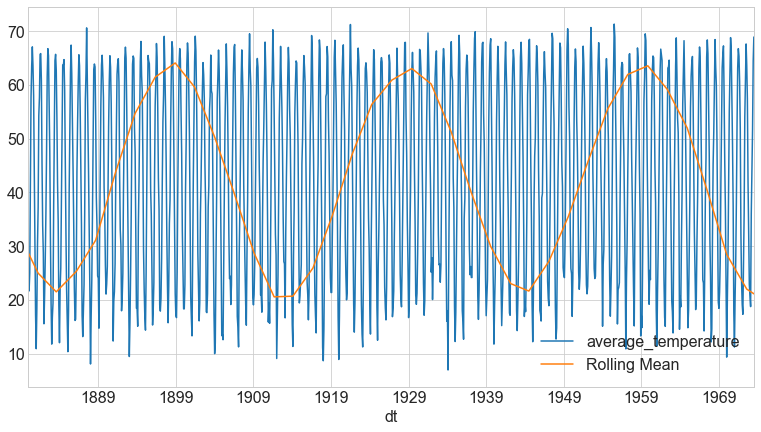

In [39]:
# plot the average temperature

train.average_temperature.plot(label="average_temperature")
plt.plot(train['average_temperature'].rolling('120D').mean(), label="Rolling Mean")
plt.legend()

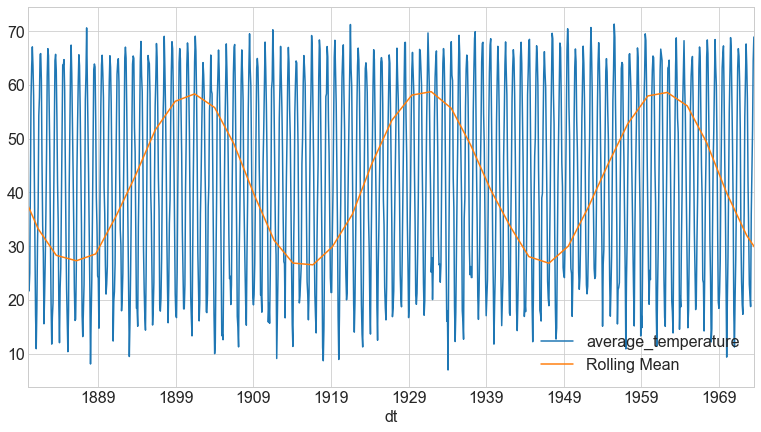

In [40]:
# plot the average temperature

train.average_temperature.plot(label="average_temperature")
plt.plot(train['average_temperature'].rolling('180D').mean(), label="Rolling Mean")
plt.legend()

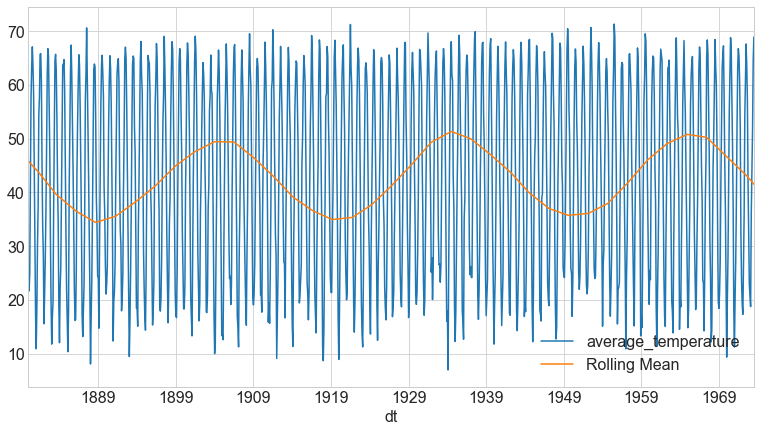

In [41]:
# plot the average temperature

train.average_temperature.plot(label="average_temperature")
plt.plot(train['average_temperature'].rolling('270D').mean(), label="Rolling Mean")
plt.legend()

---

<h2>Model</h2>

----

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [42]:
train.head()

,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
1880-01-01,24.09,0.981,Winter,January
1880-02-01,21.66,0.562,Winter,February
1880-03-01,25.02,0.800,Spring,March
1880-04-01,40.20,0.462,Spring,April
1880-05-01,57.67,0.931,Spring,May


In [43]:

cols=(['average_uncertainty', 'season_name', 'month_name'])
train.drop(columns=cols, axis=1, inplace=True)
validate.drop(columns=cols, axis=1, inplace=True)
test.drop(columns=cols, axis=1, inplace=True)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
train.head()

,average_temperature
dt,
1880-01-01,24.09
1880-02-01,21.66
1880-03-01,25.02
1880-04-01,40.20
1880-05-01,57.67


In [45]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 3)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [46]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [47]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [48]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [49]:
eval_df

,model_type,target_var,rmse


## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Average Temperature

In [50]:
# take the last item of dollars sold and assign to variable
avg_temp = round(train['average_temperature'][-1:][0], 2)
avg_temp

68.92

In [51]:
yhat_df = pd.DataFrame({'average_temperature': [avg_temp], 
                        }, 
                      index = validate.index)

yhat_df.head()

,average_temperature
dt,
1973-08-01,68.92
1973-09-01,68.92
1973-10-01,68.92
1973-11-01,68.92
1973-12-01,68.92


In [52]:
yhat_df.describe()

,average_temperature
count,3.210000e+02
mean,6.892000e+01
std,4.127582e-13
min,6.892000e+01
25%,6.892000e+01
50%,6.892000e+01
75%,6.892000e+01
max,6.892000e+01


average_temperature -- RMSE: 31


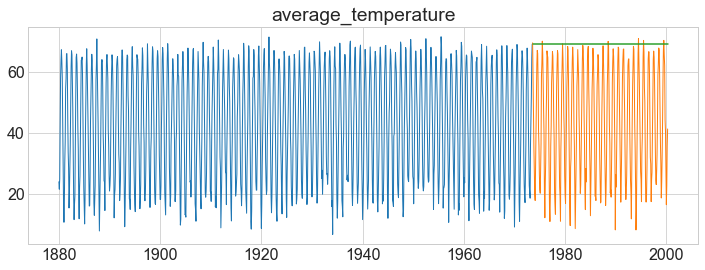

In [53]:
plot_and_eval('average_temperature')

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [54]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,31.03


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [55]:
# compute simple average
avg_temp = round(train['average_temperature'].mean(),2)
avg_temp

42.51

In [56]:
def make_predictions():
    yhat_df = pd.DataFrame({'average_temperature': [avg_temp],
                           }, 
                           index = validate.index)
    return yhat_df

In [57]:
yhat_df = make_predictions()

yhat_df.head()

,average_temperature
dt,
1973-08-01,42.51
1973-09-01,42.51
1973-10-01,42.51
1973-11-01,42.51
1973-12-01,42.51


In [58]:
yhat_df.describe()

,average_temperature
count,3.210000e+02
mean,4.251000e+01
std,1.850295e-13
min,4.251000e+01
25%,4.251000e+01
50%,4.251000e+01
75%,4.251000e+01
max,4.251000e+01


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

average_temperature -- RMSE: 18


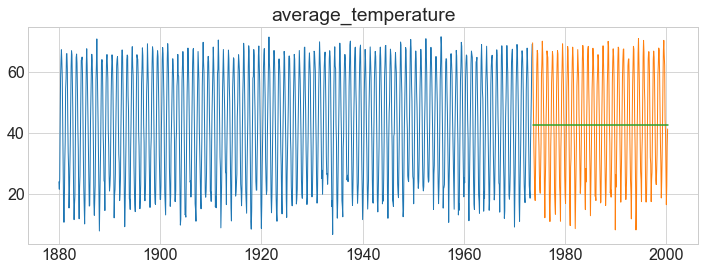

In [59]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,31.030
1,simple_average,average_temperature,17.591


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

In [61]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
avg_temp = round(train['average_temperature'].rolling(period).mean()[-1], 2)


print(avg_temp)

43.55


In [62]:
yhat_df = make_predictions()
yhat_df.head()

,average_temperature
dt,
1973-08-01,43.55
1973-09-01,43.55
1973-10-01,43.55
1973-11-01,43.55
1973-12-01,43.55


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

average_temperature -- RMSE: 18


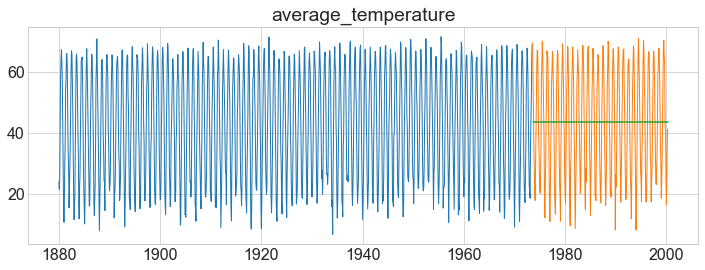

In [63]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [64]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,31.030
1,simple_average,average_temperature,17.591
2,30d_moving_avg,average_temperature,17.572


Let's look at several other periods

In [65]:
periods = [45, 60, 75, 120, 270]

for p in periods: 
    avg_temp = round(train['average_temperature'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [66]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,31.030
1,simple_average,average_temperature,17.591
2,30d_moving_avg,average_temperature,17.572
3,45d_moving_avg,average_temperature,17.622
4,60d_moving_avg,average_temperature,17.576
5,75d_moving_avg,average_temperature,17.572
6,120d_moving_avg,average_temperature,17.583
7,270d_moving_avg,average_temperature,17.572


In [67]:
min_items_rmse = eval_df[eval_df.target_var == 'average_temperature']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
2,30d_moving_avg,average_temperature,17.572
5,75d_moving_avg,average_temperature,17.572
7,270d_moving_avg,average_temperature,17.572


### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 

In [68]:
col = 'average_temperature'
# create the Hold object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

<ipython-input-68-adf63d21257c>:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train[col], exponential=False, damped=True)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [69]:
yhat_df

,average_temperature
dt,
1973-08-01,73.26
1973-09-01,76.55
1973-10-01,79.19
1973-11-01,81.30
1973-12-01,82.99
...,...
1999-12-01,89.74
2000-01-01,89.74
2000-02-01,89.74


average_temperature -- RMSE: 49


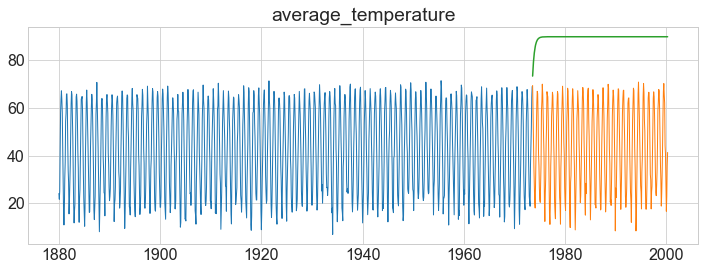

In [70]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [71]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [72]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,31.030
1,simple_average,average_temperature,17.591
2,30d_moving_avg,average_temperature,17.572
3,45d_moving_avg,average_temperature,17.622
4,60d_moving_avg,average_temperature,17.576
5,75d_moving_avg,average_temperature,17.572
6,120d_moving_avg,average_temperature,17.583
7,270d_moving_avg,average_temperature,17.572
8,holts_optimized,average_temperature,49.412


In [73]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.1, 
                      smoothing_trend=.1, 
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


average_temperature -- RMSE: 53


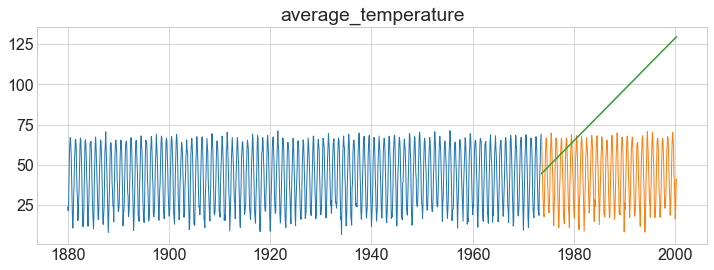

In [74]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [75]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,30d_moving_avg,average_temperature,17.572
5,75d_moving_avg,average_temperature,17.572
7,270d_moving_avg,average_temperature,17.572
4,60d_moving_avg,average_temperature,17.576
6,120d_moving_avg,average_temperature,17.583
1,simple_average,average_temperature,17.591
3,45d_moving_avg,average_temperature,17.622
0,last_observed_value,average_temperature,31.030
8,holts_optimized,average_temperature,49.412
9,holts_.1,average_temperature,53.116


### Predict Based on Previous Cycle

Take all the 2010 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 



In [76]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1572, 4)
(12, 4)
(12, 4)


,average_temperature,average_uncertainty,season_name,month_name
dt,,,,
2010-08-01,66.94,0.349,Summer,August
2010-09-01,60.85,0.241,Autumn,September
2010-10-01,46.40,0.187,Autumn,October
2010-11-01,36.38,0.248,Autumn,November
2010-12-01,22.92,0.429,Winter,December


In [77]:
cols=(['average_uncertainty', 'season_name', 'month_name'])
train.drop(columns=cols, axis=1, inplace=True)
validate.drop(columns=cols, axis=1, inplace=True)
test.drop(columns=cols, axis=1, inplace=True)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Make Predictions

In [78]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(365).mean()

In [79]:
# train['2010']
train[train.index=='2009-12-01']
# train.diff(365)

,average_temperature
dt,
2009-12-01,23.29


In [80]:
train[train.index=='2010-12-01']

,average_temperature
dt,
2010-12-01,22.92


In [81]:
train.loc['2010'].head()

,average_temperature
dt,
2010-01-01,21.08
2010-02-01,25.02
2010-03-01,37.30
2010-04-01,47.13
2010-05-01,57.75


In [82]:
yhat_df.head()

,average_temperature
dt,
2010-01-01,21.750572
2010-02-01,25.690572
2010-03-01,37.970572
2010-04-01,47.800572
2010-05-01,58.420572


In [83]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,average_temperature
dt,
2010-01-01,21.750572
2011-01-01,17.080000


In [84]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,average_temperature
dt,
2011-01-01,21.750572
2011-02-01,25.690572
2011-03-01,37.970572
2011-04-01,47.800572
2011-05-01,58.420572
2011-06-01,64.720572
2011-07-01,72.060572
2011-08-01,67.610572
2011-09-01,61.520572


In [85]:
yhat_df.shape

(12, 1)

average_temperature -- RMSE: 4


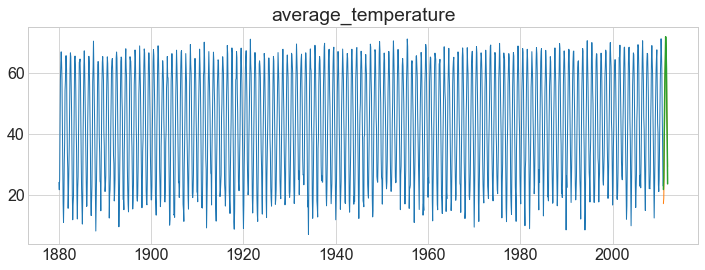

In [86]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [87]:
avgtemp_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]



# find which model that is
eval_df[((eval_df.rmse == avgtemp_min_rmse))]

,model_type,target_var,rmse
10,previous_year,average_temperature,4.294


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [88]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [89]:
yhat_df

,average_temperature
dt,
2012-01-01,17.750572
2012-02-01,19.590572
2012-03-01,30.180572
2012-04-01,43.430572
2012-05-01,57.450572
2012-06-01,63.830572
2012-07-01,70.820572
2012-08-01,67.700572
2012-09-01,62.320572


In [90]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [91]:
rmse_avgtemp = sqrt(mean_squared_error(test['average_temperature'], 
                                       yhat_df['average_temperature']))

In [92]:
print('rmse_avgtemp: ', rmse_avgtemp)

rmse_avgtemp:  4.266757011900791


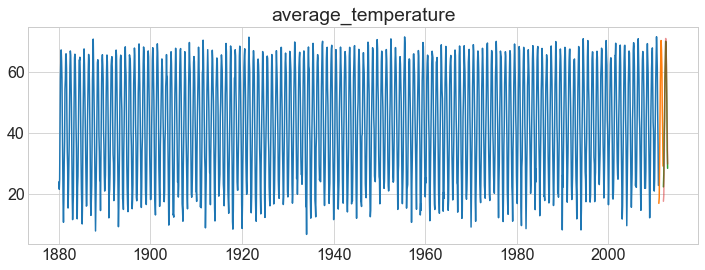

In [93]:
for col in train.columns:
    final_plot(col)

In [94]:
# to predict 2013

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [95]:
yhat_df.head()

,average_temperature
dt,
2012-12-31 05:49:12,23.110572
2013-01-31 05:49:12,27.270572
2013-03-01 05:49:12,39.550572
2013-04-01 05:49:12,45.430572
2013-05-01 05:49:12,58.750572


In [96]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

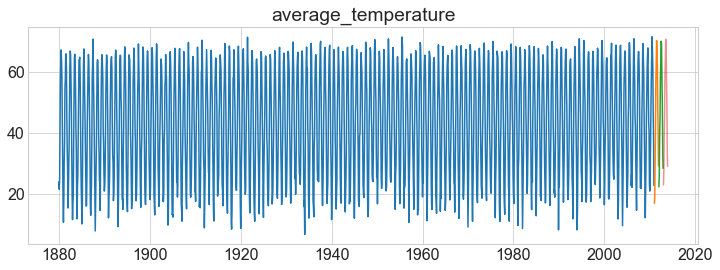

In [97]:
for col in train.columns:
    final_plot(col)

---

<h2>Conclusion</h2>

----

- Predicting based on a previous cycle ended up working the best out of the forecasting models
- There has been an upward trend of temperature has the years have progressed since 1880
- Would like to have high and low temperature by day to get a more indepth look
- Combining this set with a precipitation set could produce interesting results and see if there is seasonality correlation with rainfall and temp